In [2]:
import pandas as pd
from pathlib import Path
import numpy as np 
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "..")   
from src.cluster_util import cluster_data
from src.data_utils import build_feature_and_label_cols, X_FEATURES, Y_FEATURES, WEIGHT_COLUMN
from src.model_utils import create_X_y_dataset
from src.BinaryTriFactorizationEstimator import BinaryTriFactorizationEstimator
from src.BTNMF_util import  get_normalized_assignments, sweep_btf_grid, sweep_btf_grid
from src.BTNMF_util import get_sorted_row_col, pick_best_btf_setting
from src.data_utils import save_csv_or_parquet, normalize_data, build_growth_features_for_clustering, sort_df, load_raw_data
from src.plot_util import plot_block_annot_heatmap


In [1]:
%reload_ext autoreload
%autoreload 2

In [3]:
%pwd

'/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook'

In [17]:
df = pd.read_csv("../data/20250707_train.csv", low_memory=True)
df.head()

/var/folders/w3/d06m5l_97yn4bnxd5t6cgbjr0000gn/T/ipykernel_19955/3711264053.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/20250707_train.csv")


,date,store_item,store,item,id,unit_sales,onpromotion
0,2013-01-01,25_103665,25,103665,0,7.000,NaN
1,2013-01-01,25_819209,25,819209,382,1.788,NaN
2,2013-01-01,25_819231,25,819231,383,1.055,NaN
3,2013-01-01,25_823245,25,823245,384,2.000,NaN
4,2013-01-01,25_827911,25,827911,385,2.000,NaN


In [95]:
df.query("store_item == '10_1000866'")

,store,item,date,store_item,unit_sales,id,onpromotion,weight
0,10,1000866,2014-01-01,10_1000866,NaN,NaN,None,1
94000,10,1000866,2014-01-02,10_1000866,NaN,NaN,None,1
188000,10,1000866,2014-01-03,10_1000866,NaN,NaN,None,1
282000,10,1000866,2014-01-04,10_1000866,NaN,NaN,None,1
376000,10,1000866,2014-01-05,10_1000866,NaN,NaN,None,1
470000,10,1000866,2014-01-06,10_1000866,NaN,NaN,None,1
564000,10,1000866,2014-01-07,10_1000866,NaN,NaN,None,1
658000,10,1000866,2014-01-08,10_1000866,NaN,NaN,None,1
752000,10,1000866,2014-01-09,10_1000866,NaN,NaN,None,1
846000,10,1000866,2014-01-10,10_1000866,NaN,NaN,None,1


In [93]:
df = pd.read_parquet("../output/data/2014_January_top_53_store_2000_item.parquet")
df.head()

,store,item,date,store_item,unit_sales,id,onpromotion,weight
0,10,1000866,2014-01-01,10_1000866,NaN,NaN,None,1
1,10,1001305,2014-01-01,10_1001305,NaN,NaN,None,1
2,10,1003679,2014-01-01,10_1003679,NaN,NaN,None,1
3,10,1004545,2014-01-01,10_1004545,NaN,NaN,None,1
4,10,1004550,2014-01-01,10_1004550,NaN,NaN,None,1


In [94]:
print(df["store"].nunique())
print(df["item"].nunique())

47
2000


In [38]:
df.query("store_item == '10_999547'")

,store,item,date,store_item,unit_sales,id,onpromotion,weight
1999,10,999547,2014-01-01,10_999547,NaN,NaN,None,1
95999,10,999547,2014-01-02,10_999547,NaN,NaN,None,1
189999,10,999547,2014-01-03,10_999547,5.0,16407149.0,None,1
283999,10,999547,2014-01-04,10_999547,1.0,16472860.0,None,1
377999,10,999547,2014-01-05,10_999547,2.0,16541306.0,None,1
471999,10,999547,2014-01-06,10_999547,NaN,NaN,None,1
565999,10,999547,2014-01-07,10_999547,NaN,NaN,None,1
659999,10,999547,2014-01-08,10_999547,NaN,NaN,None,1
753999,10,999547,2014-01-09,10_999547,3.0,16796860.0,None,1
847999,10,999547,2014-01-10,10_999547,1.0,16859001.0,None,1


In [4]:
data_path = Path("../output/data/2014_January_top_53_store_2000_item_weekly_growth_rate.parquet")
df = pd.read_parquet(data_path)

In [5]:
df.head()

,store_item,date,sales_wk,growth_rate,direction,growth_up,growth_sideways,growth_down,week_end
0,10_1000866,2014-01-05,0.0,NaN,0,NaN,1.0,NaN,2014-01-05
1,10_1000866,2014-01-12,0.0,NaN,0,NaN,1.0,NaN,2014-01-12
2,10_1000866,2014-01-19,0.0,NaN,0,NaN,1.0,NaN,2014-01-19
3,10_1000866,2014-01-26,0.0,NaN,0,NaN,1.0,NaN,2014-01-26
4,10_1000866,2014-02-02,0.0,NaN,0,NaN,1.0,NaN,2014-02-02


In [6]:
df.describe()

,date,sales_wk,growth_rate,direction,growth_up,growth_sideways,growth_down,week_end
count,470000,470000.000000,245475.000000,470000.000000,96599.0,247390.0,126011.0,470000
mean,2014-01-18 23:59:59.999999744,34.172959,0.114894,-0.062579,1.0,1.0,1.0,2014-01-18 23:59:59.999999744
min,2014-01-05 00:00:00,-170.000000,-1.000000,-1.000000,1.0,1.0,1.0,2014-01-05 00:00:00
25%,2014-01-12 00:00:00,0.000000,-0.388889,-1.000000,1.0,1.0,1.0,2014-01-12 00:00:00
50%,2014-01-19 00:00:00,8.000000,-0.066901,0.000000,1.0,1.0,1.0,2014-01-19 00:00:00
75%,2014-01-26 00:00:00,32.000000,0.326083,0.000000,1.0,1.0,1.0,2014-01-26 00:00:00
max,2014-02-02 00:00:00,10010.000000,5.000000,1.000000,1.0,1.0,1.0,2014-02-02 00:00:00
std,NaN,95.931411,0.915263,0.685364,0.0,0.0,0.0,NaN


In [7]:
df.query("store_item == '10_1000866'")

,store_item,date,sales_wk,growth_rate,direction,growth_up,growth_sideways,growth_down,week_end
0,10_1000866,2014-01-05,0.0,NaN,0,NaN,1.0,NaN,2014-01-05
1,10_1000866,2014-01-12,0.0,NaN,0,NaN,1.0,NaN,2014-01-12
2,10_1000866,2014-01-19,0.0,NaN,0,NaN,1.0,NaN,2014-01-19
3,10_1000866,2014-01-26,0.0,NaN,0,NaN,1.0,NaN,2014-01-26
4,10_1000866,2014-02-02,0.0,NaN,0,NaN,1.0,NaN,2014-02-02


In [8]:
df.query("store_item == '10_999547'")

,store_item,date,sales_wk,growth_rate,direction,growth_up,growth_sideways,growth_down,week_end
9995,10_999547,2014-01-05,8.0,NaN,0,NaN,1.0,NaN,2014-01-05
9996,10_999547,2014-01-12,8.0,0.000000,0,NaN,1.0,NaN,2014-01-12
9997,10_999547,2014-01-19,19.0,1.375000,1,1.0,NaN,NaN,2014-01-19
9998,10_999547,2014-01-26,20.0,0.052632,1,1.0,NaN,NaN,2014-01-26
9999,10_999547,2014-02-02,8.0,-0.600000,-1,NaN,NaN,1.0,2014-02-02


In [10]:
df["store"] = df["store_item"].str.split("_").str[0].astype(int)
df["item"] = df["store_item"].str.split("_").str[1].astype(int)

In [11]:
df.query("store == 10")

,store_item,date,sales_wk,growth_rate,direction,growth_up,growth_sideways,growth_down,week_end,store,item
0,10_1000866,2014-01-05,0.0,NaN,0,NaN,1.0,NaN,2014-01-05,10,1000866
1,10_1000866,2014-01-12,0.0,NaN,0,NaN,1.0,NaN,2014-01-12,10,1000866
2,10_1000866,2014-01-19,0.0,NaN,0,NaN,1.0,NaN,2014-01-19,10,1000866
3,10_1000866,2014-01-26,0.0,NaN,0,NaN,1.0,NaN,2014-01-26,10,1000866
4,10_1000866,2014-02-02,0.0,NaN,0,NaN,1.0,NaN,2014-02-02,10,1000866
...,...,...,...,...,...,...,...,...,...,...,...
9995,10_999547,2014-01-05,8.0,NaN,0,NaN,1.0,NaN,2014-01-05,10,999547
9996,10_999547,2014-01-12,8.0,0.000000,0,NaN,1.0,NaN,2014-01-12,10,999547
9997,10_999547,2014-01-19,19.0,1.375000,1,1.0,NaN,NaN,2014-01-19,10,999547
9998,10_999547,2014-01-26,20.0,0.052632,1,1.0,NaN,NaN,2014-01-26,10,999547


In [12]:
df2 = df.query("store == 10")
df2.head()

,store_item,date,sales_wk,growth_rate,direction,growth_up,growth_sideways,growth_down,week_end,store,item
0,10_1000866,2014-01-05,0.0,NaN,0,NaN,1.0,NaN,2014-01-05,10,1000866
1,10_1000866,2014-01-12,0.0,NaN,0,NaN,1.0,NaN,2014-01-12,10,1000866
2,10_1000866,2014-01-19,0.0,NaN,0,NaN,1.0,NaN,2014-01-19,10,1000866
3,10_1000866,2014-01-26,0.0,NaN,0,NaN,1.0,NaN,2014-01-26,10,1000866
4,10_1000866,2014-02-02,0.0,NaN,0,NaN,1.0,NaN,2014-02-02,10,1000866


In [31]:
g = df2.assign(
        gc=pd.to_numeric(g["growth_rate"], errors="coerce"),
        up=pd.to_numeric(g["growth_up"], errors="coerce"),
        sw=pd.to_numeric(g["growth_sideways"], errors="coerce"),
        dn=pd.to_numeric(g["growth_down"], errors="coerce"),
)
iqr_gc = (
        "gc",
        lambda s: np.nanpercentile(pd.to_numeric(s, "coerce"), 75)
        - np.nanpercentile(pd.to_numeric(s, "coerce"), 25),
)
g

,store_item,date,sales_wk,growth_rate,direction,growth_up,growth_sideways,growth_down,week_end,store,item,gc,up,sw,dn
0,10_1000866,2014-01-05,0.0,NaN,0,NaN,1.0,NaN,2014-01-05,10,1000866,NaN,NaN,1.0,NaN
1,10_1000866,2014-01-12,0.0,NaN,0,NaN,1.0,NaN,2014-01-12,10,1000866,NaN,NaN,1.0,NaN
2,10_1000866,2014-01-19,0.0,NaN,0,NaN,1.0,NaN,2014-01-19,10,1000866,NaN,NaN,1.0,NaN
3,10_1000866,2014-01-26,0.0,NaN,0,NaN,1.0,NaN,2014-01-26,10,1000866,NaN,NaN,1.0,NaN
4,10_1000866,2014-02-02,0.0,NaN,0,NaN,1.0,NaN,2014-02-02,10,1000866,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,10_999547,2014-01-05,8.0,NaN,0,NaN,1.0,NaN,2014-01-05,10,999547,NaN,NaN,1.0,NaN
9996,10_999547,2014-01-12,8.0,0.000000,0,NaN,1.0,NaN,2014-01-12,10,999547,0.000000,NaN,1.0,NaN
9997,10_999547,2014-01-19,19.0,1.375000,1,1.0,NaN,NaN,2014-01-19,10,999547,1.375000,1.0,NaN,NaN
9998,10_999547,2014-01-26,20.0,0.052632,1,1.0,NaN,NaN,2014-01-26,10,999547,0.052632,1.0,NaN,NaN


In [32]:
iqr_gc

('gc', <function __main__.<lambda>(s)>)

In [58]:
tau = 0.05
feats = g.groupby("store_item").agg(gc_median=("gc", "median"),
                                      gc_iqr=iqr_gc,
                                      frac_up=("up",
                                        lambda s: np.nanmean(pd.to_numeric(s, errors="coerce"))),
                                      frac_sideways=(
                                                    "sw",
                                        lambda s: np.nanmean(pd.to_numeric(s, errors="coerce")),
                ),
                                    frac_down=(
                                                    "dn",
                                        lambda s: np.nanmean(pd.to_numeric(s, errors="coerce")),
                ),
                                     up_to_down_ratio=(
                "gc",
                lambda s: (
                    (lambda pos, neg: np.nan if neg == 0 else pos / neg)(
                        np.sum(pd.to_numeric(s, errors="coerce") > tau),
                        np.sum(pd.to_numeric(s, errors="coerce") < -tau),
                    )
                ),
            ),
        ).reset_index()
feats

/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/var/folders/w3/d06m5l_97yn4bnxd5t6cgbjr0000gn/T/ipykernel_96341/2091532901.py:5: RuntimeWarning: Mean of empty slice
  lambda s: np.nanmean(pd.to_numeric(s, errors="coerce"))),
/var/folders/w3/d06m5l_97yn4bnxd5t6cgbjr0000gn/T/ipykernel_96341/2091532901.py:12: RuntimeWarning: Mean of empty slice
  lambda s: np.nanmean(pd.to_numeric(s, errors="coerce")),


,store_item,gc_median,gc_iqr,frac_up,frac_sideways,frac_down,up_to_down_ratio
0,10_1000866,NaN,NaN,NaN,1.0,NaN,NaN
1,10_1001305,NaN,NaN,NaN,1.0,NaN,NaN
2,10_1003679,-0.081169,0.195860,1.0,1.0,1.0,0.333333
3,10_1004545,NaN,NaN,NaN,1.0,NaN,NaN
4,10_1004550,-0.107143,2.375000,1.0,1.0,1.0,1.000000
...,...,...,...,...,...,...,...
1995,10_996537,NaN,NaN,NaN,1.0,NaN,NaN
1996,10_996597,NaN,NaN,NaN,1.0,NaN,NaN
1997,10_996600,NaN,NaN,NaN,1.0,NaN,NaN
1998,10_996606,NaN,NaN,NaN,1.0,NaN,NaN


In [42]:
feats.query("store_item == '10_999547'")

,store_item,gc_median,gc_iqr,frac_up,frac_sideways,frac_down,up_to_down_ratio
1999,10_999547,0.026316,0.533224,1.0,1.0,1.0,2.0


In [43]:
feats.query("store_item == '10_1000866'")

,store_item,gc_median,gc_iqr,frac_up,frac_sideways,frac_down,up_to_down_ratio
0,10_1000866,NaN,NaN,NaN,1.0,NaN,NaN


In [21]:
g.groupby(["store_item"], sort=False)

In [54]:
df3 = df2.query("store_item == '10_999547'")        
gr_sm = df3["growth_rate"].rolling(2, min_periods=1).median()
df3

,store_item,date,sales_wk,growth_rate,direction,growth_up,growth_sideways,growth_down,week_end,store,item
9995,10_999547,2014-01-05,8.0,NaN,0,NaN,1.0,NaN,2014-01-05,10,999547
9996,10_999547,2014-01-12,8.0,0.000000,0,NaN,1.0,NaN,2014-01-12,10,999547
9997,10_999547,2014-01-19,19.0,1.375000,1,1.0,NaN,NaN,2014-01-19,10,999547
9998,10_999547,2014-01-26,20.0,0.052632,1,1.0,NaN,NaN,2014-01-26,10,999547
9999,10_999547,2014-02-02,8.0,-0.600000,-1,NaN,NaN,1.0,2014-02-02,10,999547


In [55]:
gr_sm

9995         NaN
9996    0.000000
9997    0.687500
9998    0.713816
9999   -0.273684
Name: growth_rate, dtype: float64

In [56]:
def _safe_autocorr(x: pd.Series, lag: int) -> float:
    """
    compute the lag-lag autocorrelation (i.e.,
    Pearson correlation between x_t and x_{t−lag})
    while being robust to NaNs and tiny samples.
    """
    x = pd.to_numeric(x, errors="coerce").astype(float)
    if x.isna().sum() > len(x) - 3 or len(x) <= lag + 2:
        return np.nan
    a = x.values
    b = np.roll(a, lag)
    b[:lag] = np.nan
    ok = ~np.isnan(a) & ~np.isnan(b)
    if ok.sum() < 3:
        return np.nan
    a0, b0 = a[ok] - a[ok].mean(), b[ok] - b[ok].mean()
    denom = a0.std(ddof=1) * b0.std(ddof=1)
    return (a0 * b0).mean() / denom if denom > 0 else np.nan

In [57]:
_safe_autocorr(gr_sm, 1)


-0.33859016673600334

In [29]:
rows = []
for key_vals, sub in g.groupby(["store_item"], sort=False):
    sub = sub.sort_values("date", kind="mergesort")
    gr = pd.to_numeric(sub["gc"], errors="coerce")
    gr_med = (np.nanmedian(gr) if gr.notna().any() else np.nan)
    row = {"store_item": key_vals,
           "gr_median": gr_med,
           }
    rows.append(row)

In [30]:
rows

[{'store_item': ('10_1000866',), 'gr_median': nan},
 {'store_item': ('10_1001305',), 'gr_median': nan},
 {'store_item': ('10_1003679',), 'gr_median': -0.08116883116883117},
 {'store_item': ('10_1004545',), 'gr_median': nan},
 {'store_item': ('10_1004550',), 'gr_median': -0.10714285714285715},
 {'store_item': ('10_1004551',), 'gr_median': 0.0},
 {'store_item': ('10_1005456',), 'gr_median': nan},
 {'store_item': ('10_1005458',), 'gr_median': nan},
 {'store_item': ('10_1005461',), 'gr_median': nan},
 {'store_item': ('10_1005463',), 'gr_median': nan},
 {'store_item': ('10_1005464',), 'gr_median': nan},
 {'store_item': ('10_1005465',), 'gr_median': nan},
 {'store_item': ('10_1009512',), 'gr_median': -1.0},
 {'store_item': ('10_1009539',), 'gr_median': -0.16666666666666669},
 {'store_item': ('10_1009946',), 'gr_median': nan},
 {'store_item': ('10_1009997',), 'gr_median': nan},
 {'store_item': ('10_1009998',), 'gr_median': nan},
 {'store_item': ('10_1010752',), 'gr_median': nan},
 {'store_ite

In [150]:
cluster_df, features_df, diag = build_growth_features_for_clustering(
            df.query("store == 10"),
            keys=("store_item",),
            tau=0.05,
            include_pca_smoothed=False,
            pca_components=4,
            smooth_window=4,
)

2025-10-03 16:22:32,740 - INFO - Building features for clustering...
2025-10-03 16:22:32,741 - INFO - Building base series...
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
2025-10-03 16:22:35,806 - INFO - Computing autocorrs, trend, seasonality...
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype

In [146]:
cluster_df

,store_item,gc_mean,gc_median,gc_std,gc_iqr,gr_mean,gr_std,gr_iqr,frac_nonzero,frac_up,frac_down,pos_to_neg_ratio,big_move_rate,ac_lag1,median_up,median_down_mag
0,10_999547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [147]:
cluster_df.query("store_item == '10_999547'")

,store_item,gc_mean,gc_median,gc_std,gc_iqr,gr_mean,gr_std,gr_iqr,frac_nonzero,frac_up,frac_down,pos_to_neg_ratio,big_move_rate,ac_lag1,median_up,median_down_mag
0,10_999547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
cluster_df.query("store_item == '10_1000866'")

,store_item,gc_mean,gc_median,gc_std,gc_iqr,gr_mean,gr_std,gr_iqr,frac_nonzero,frac_up,frac_down,pos_to_neg_ratio,big_move_rate,ac_lag1,ac_lag4,median_up,median_down_mag
0,10_1000866,0.100986,0.098404,0.008872,0.008872,0.259412,0.146643,0.090722,0.0,0.0,0.0,0.166667,0.0,0.67443,0.267949,0.098018,0.391608


In [151]:
features_df.query("store_item == '10_999547'")

,store_item,gc_mean,gc_median,gc_std,gc_iqr,gr_mean,gr_std,gr_iqr,frac_nonzero,frac_up,...,ac_lag12,trend_slope,seasonal_strength,gr_median_nz,gr_trimmed_mean_10_90,gr_huber_mean_q01_q99,gr_median_abs,gr_share_zero,median_up,median_down_mag
1999,10_999547,0.713816,0.713816,0.935056,0.661184,0.206908,0.833097,0.533224,0.6,0.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.713816,0.6


In [15]:

data_path = Path("../output/data/2014_January_top_53_store_2000_item_growth_rate_input_clustered.parquet")
df = pd.read_parquet(data_path)
df.head(10)

,store_item,gc_mean,gc_median,gc_std,gc_iqr,frac_up,frac_down,pos_to_neg_ratio,ac_lag1,ac_lag4,gr_median_up,gr_median_down,gr_median_sideways
0,10_1000866,0.165671,0.155569,0.117118,0.077303,0.102200,0.368421,0.333333,0.750000,0.267949,0.099327,0.364875,0.499962
1,10_1001305,0.165671,0.155569,0.117118,0.077303,0.102200,0.368421,0.333333,0.750000,0.267949,0.099327,0.364875,0.499962
2,10_1003679,0.178503,0.155734,0.071600,0.029269,0.111111,0.048189,0.333333,0.100552,0.267949,0.111111,0.043062,0.499962
3,10_1004545,0.165671,0.155569,0.117118,0.077303,0.102200,0.368421,0.333333,0.750000,0.267949,0.099327,0.364875,0.499962
4,10_1004550,0.327482,0.142857,0.648208,0.389722,0.545455,0.774436,0.333333,0.053641,0.267949,0.545455,0.774436,0.499962
5,10_1004551,0.168079,0.161017,0.072682,0.031406,0.090909,0.298246,0.333333,0.213921,0.267949,0.090909,0.298246,0.499962
6,10_1005456,0.165671,0.155569,0.117118,0.077303,0.102200,0.368421,0.333333,0.750000,0.267949,0.099327,0.364875,0.499962
7,10_1005458,0.165671,0.155569,0.117118,0.077303,0.102200,0.368421,0.333333,0.750000,0.267949,0.099327,0.364875,0.499962
8,10_1005461,0.165671,0.155569,0.117118,0.077303,0.102200,0.368421,0.333333,0.750000,0.267949,0.099327,0.364875,0.499962
9,10_1005463,0.165671,0.155569,0.117118,0.077303,0.102200,0.368421,0.333333,0.750000,0.267949,0.099327,0.364875,0.499962


In [16]:
df.columns

Index(['store_item', 'gc_mean', 'gc_median', 'gc_std', 'gc_iqr', 'frac_up',
       'frac_down', 'pos_to_neg_ratio', 'ac_lag1', 'ac_lag4', 'gr_median_up',
       'gr_median_down', 'gr_median_sideways'],
      dtype='object')

In [17]:
df.query("store_item == '10_999547'")

,store_item,gc_mean,gc_median,gc_std,gc_iqr,frac_up,frac_down,pos_to_neg_ratio,ac_lag1,ac_lag4,gr_median_up,gr_median_down,gr_median_sideways
1999,10_999547,0.193967,0.16124,0.191105,0.080638,0.134104,0.578947,0.333333,0.185427,0.267949,0.134104,0.578947,0.499962


In [18]:

data_path = Path("../output/data/2014_January_top_53_store_2000_item_growth_rate_features.parquet")
df = pd.read_parquet(data_path)
df.head(10)

,store_item,gc_mean,gc_median,gc_std,gc_iqr,frac_up,frac_down,pos_to_neg_ratio,ac_lag1,ac_lag4,ac_lag12,trend_slope,seasonal_strength,gr_median_nz,gr_median_up,gr_median_down,gr_median_sideways
0,10_1000866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10_1001305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10_1003679,0.103166,-0.031169,0.298711,0.170860,0.60,0.095779,1.0,-0.532598,NaN,NaN,NaN,NaN,NaN,0.60,0.090909,NaN
3,10_1004545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10_1004550,0.982143,-0.107143,2.704277,2.275000,2.75,0.785714,1.0,-0.595145,NaN,NaN,NaN,NaN,NaN,2.75,0.785714,NaN
5,10_1004551,0.041667,0.000000,0.303223,0.183333,0.50,0.333333,1.0,-0.381439,NaN,NaN,NaN,NaN,NaN,0.50,0.333333,0.0
6,10_1005456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,10_1005458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,10_1005461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10_1005463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df.query("store_item == '10_999547'")

,store_item,gc_mean,gc_median,gc_std,gc_iqr,frac_up,frac_down,pos_to_neg_ratio,ac_lag1,ac_lag4,ac_lag12,trend_slope,seasonal_strength,gr_median_nz,gr_median_up,gr_median_down,gr_median_sideways
1999,10_999547,0.194408,0.001316,0.797278,0.470724,0.713816,0.6,1.0,-0.419431,NaN,NaN,NaN,NaN,NaN,0.713816,0.6,0.0


In [188]:
data_path = Path("../output/data/2014_January_top_53_store_2000_item_growth_rate_clustered.parquet")
df = pd.read_parquet(data_path)
df.head()

,store_item,gc_mean,gc_median,gc_std,gc_iqr,gr_mean,gr_std,gr_iqr,frac_nonzero,frac_up,frac_down,pos_to_neg_ratio,big_move_rate,ac_lag1,ac_lag4,median_up,median_down_mag,block_id
0,10_1000866,0.254694,0.250927,0.070478,0.017176,0.170819,0.125976,0.085204,0.0,0.00,0.00,0.333333,0.0,0.737319,0.267949,0.100032,0.374620,14281
1,10_1001305,0.254694,0.250927,0.070478,0.017176,0.170819,0.125976,0.085204,0.0,0.00,0.00,0.333333,0.0,0.737319,0.267949,0.100032,0.374620,14281
2,10_1003679,0.266667,0.266667,0.070478,0.000000,0.179694,0.082164,0.032987,1.0,0.25,0.75,0.111111,0.5,0.101388,0.267949,0.118200,0.080743,14281
3,10_1004545,0.254694,0.250927,0.070478,0.017176,0.170819,0.125976,0.085204,0.0,0.00,0.00,0.333333,0.0,0.737319,0.267949,0.100032,0.374620,14281
4,10_1004550,0.625000,0.625000,0.750000,0.566819,0.330357,0.647452,0.400000,1.0,0.50,0.50,0.333333,1.0,0.050326,0.267949,0.549080,0.783318,14281


In [189]:
df.query("store_item == '10_999547'")

,store_item,gc_mean,gc_median,gc_std,gc_iqr,gr_mean,gr_std,gr_iqr,frac_nonzero,frac_up,frac_down,pos_to_neg_ratio,big_move_rate,ac_lag1,ac_lag4,median_up,median_down_mag,block_id
1999,10_999547,0.285636,0.285636,0.220395,0.166565,0.201151,0.196363,0.089806,0.75,0.5,0.25,0.666667,0.5,0.188257,0.267949,0.14101,0.595527,14281


In [190]:
print(df['block_id'].nunique())
df['block_id'].value_counts()

4


block_id
14281    87830
14357     3549
14110     2582
14420       39
Name: count, dtype: int64

In [191]:
df["store"] = df["store_item"].str.split("_").str[0].astype(int)
df["item"] = df["store_item"].str.split("_").str[1].astype(int)
print(df["store"].nunique())
print(df["item"].nunique())

47
2000


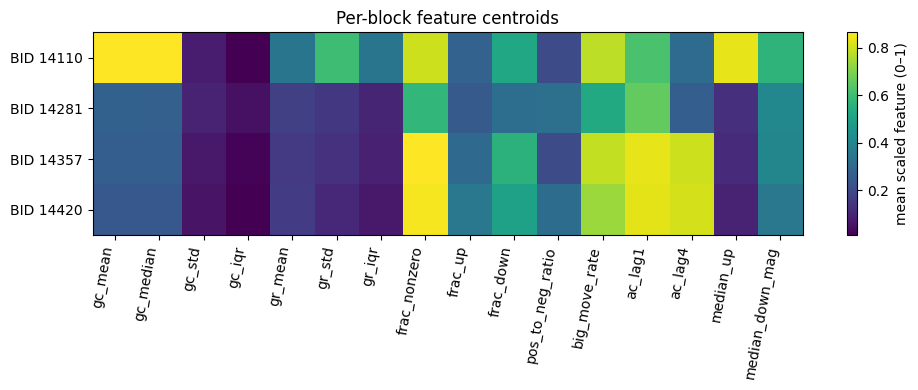

In [ ]:
feat_names = [
    'gc_mean','gc_median','gc_std','gc_iqr','gr_mean','gr_std','gr_iqr',
    'frac_nonzero','frac_up','frac_down','pos_to_neg_ratio',
    'big_move_rate','ac_lag1','ac_lag4','median_up','median_down_mag'
]
centroids = df.groupby("block_id")[feat_names].mean().sort_index()

plt.figure(figsize=(10, 0.5*len(centroids)+2))
im = plt.imshow(centroids.values, aspect="auto", cmap="viridis")
plt.colorbar(im, label="mean scaled feature (0–1)")
plt.yticks(range(len(centroids)), [f"BID {b}" for b in centroids.index])
plt.xticks(range(len(feat_names)), feat_names, rotation=80, ha="right")
plt.title("Per-block feature centroids")
plt.tight_layout()
plt.show()


In [174]:
model_path = Path("../output/data/2014_January_top_53_store_2000_item_growth_rate_clustered_model.pickle")
import pickle
with open(model_path, "rb") as f:
    model_data = pickle.load(f)

In [175]:
model_data

{'U': array([[0, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int8),
 'V': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0]], dtype=int8),
 'B': array([[ 0.        ,  0.00202563, -0.00255704, ...,  0.        ,
          0.00667034,  0.        ],
        [ 0.        ,  0.00127882,  0.00154426, ...,  0.        ,
          0.00469812,  0.        ],
        [ 0.        , -0.00908657, -0.00126534, ...,  0.        ,
          0.00428655,  0.        ],
        ...,
        [ 0.        ,  0.0166388 , -0.00360951, ...,  0.        ,
          0.00611072,  0.        ],
        [ 0.        , -0.00335717, -0.00227049, ...,  0.        ,
          0.00105083,  0.        ],
        [ 0.

In [176]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif

# --- Inputs ---
# M_btnmf: columns = ["store_item", feat1, feat2, ...] (scaled 0..1)
# est: your fitted tri-factorization model with U_, V_, B_

X = df.drop(columns=["store_item"]).to_numpy(dtype=float)
row_ids = df["store_item"].astype(str).to_numpy()

# Row cluster labels from U (hard assignment)
U = model_data["U"]
row_labels = np.asarray(U).argmax(axis=1)  # shape (n_rows,)
K = int(row_labels.max() + 1)

# Standardized features for projections (keeps per-feature contrast)
Xs = StandardScaler(with_mean=True, with_std=True).fit_transform(X)
feat_names = df.columns[1:].tolist()


In [178]:
row_labels

array([ 2,  2, 11, ...,  5,  2,  3])

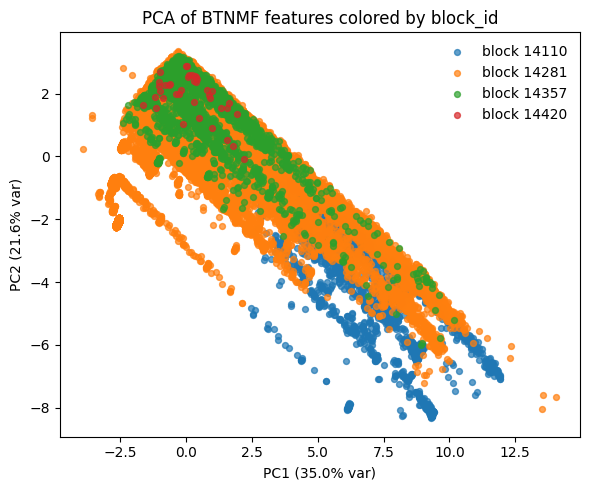

In [182]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA projection of standardized features
pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(Xs)

# Map each row back to its block_id (after filtering)
row_block_ids = df.set_index("store_item")["block_id"].reindex(df["store_item"]).to_numpy()

plt.figure(figsize=(6,5))
for bid in np.unique(row_block_ids):
    idx = row_block_ids == bid
    plt.scatter(Z[idx,0], Z[idx,1], s=18, alpha=0.7, label=f"block {bid}")

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("PCA of BTNMF features colored by block_id")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


In [183]:
# Merge block_id assignments into the feature matrix
df2 = df.copy()
df2 = df2.merge(out[["store_item", "block_id"]], on="store_item", how="left")

# Compute per-block centroids (scaled features)
centroids = df2.groupby("block_id")[feat_names].mean()

plt.figure(figsize=(max(6, 0.35*len(feat_names)), 0.6*centroids.shape[0] + 2))
plt.imshow(centroids.values, aspect="auto")
plt.colorbar(label="scaled feature (0..1)")
plt.yticks(range(centroids.shape[0]), [f"block {bid}" for bid in centroids.index])
plt.xticks(range(len(feat_names)), feat_names, rotation=80, ha="right")
plt.title("Block centroids (mean of scaled features)")
plt.tight_layout()
plt.show()


NameError: name 'out' is not defined

In [3]:
data_path = Path("../output/data/2014_January_top_53_store_2000_item_growth_rate_clustered_medians_cyc_X_y_features.parquet")
df = pd.read_parquet(data_path)

In [4]:
df.head(10)

,store,item,date,store_item,unit_sales,onpromotion,weight,growth_rate,block_id,cluster_growth_rate_median,...,growth_rate_arima,unit_sales_block,bid_unit_sales_arima,growth_rate_block,bid_growth_rate_arima,y,unit_sales_arima_tplus1,growth_rate_arima_tplus1,bid_unit_sales_arima_tplus1,bid_growth_rate_arima_tplus1
806062,25,1003679,2014-01-01,25_1003679,3.000,None,1,NaN,14148,-0.240385,...,NaN,1060.069802,NaN,0.0,NaN,0.000000,NaN,NaN,NaN,NaN
806124,25,1004550,2014-01-01,25_1004550,36.000,None,1,35.00000,14148,-0.240385,...,NaN,1060.069802,NaN,0.0,NaN,-0.361111,NaN,NaN,NaN,NaN
806155,25,1004551,2014-01-01,25_1004551,20.000,None,1,-0.62963,8830,0.000000,...,NaN,1122.462498,NaN,0.0,NaN,0.800000,NaN,NaN,NaN,NaN
806496,25,1009998,2014-01-01,25_1009998,2.000,None,1,-0.60000,878,-0.444444,...,NaN,3726.517003,NaN,0.0,NaN,1.000000,NaN,NaN,NaN,NaN
806651,25,1014865,2014-01-01,25_1014865,7.000,None,1,NaN,878,-0.444444,...,NaN,3726.517003,NaN,0.0,NaN,-0.285714,NaN,NaN,NaN,NaN
806775,25,1018878,2014-01-01,25_1018878,9.000,None,1,3.50000,14148,-0.240385,...,NaN,1060.069802,NaN,0.0,NaN,-0.444444,NaN,NaN,NaN,NaN
806899,25,1022053,2014-01-01,25_1022053,1.000,None,1,0.00000,14148,-0.240385,...,NaN,1060.069802,NaN,0.0,NaN,2.000000,NaN,NaN,NaN,NaN
806992,25,1028589,2014-01-01,25_1028589,27.000,None,1,NaN,878,-0.444444,...,NaN,3726.517003,NaN,0.0,NaN,-0.666667,NaN,NaN,NaN,NaN
807085,25,1036189,2014-01-01,25_1036189,1.833,None,1,NaN,14148,-0.240385,...,NaN,1060.069802,NaN,0.0,NaN,-0.539553,NaN,NaN,NaN,NaN
807178,25,103665,2014-01-01,25_103665,4.000,None,1,NaN,878,-0.444444,...,NaN,3726.517003,NaN,0.0,NaN,-0.500000,NaN,NaN,NaN,NaN


In [6]:
df.columns

Index(['store', 'item', 'date', 'store_item', 'unit_sales', 'onpromotion',
       'weight', 'growth_rate', 'block_id', 'cluster_growth_rate_median',
       'cluster_unit_sales_median', 'dayofweek', 'weekofmonth', 'monthofyear',
       'dayofweek_sin', 'dayofweek_cos', 'weekofmonth_sin', 'weekofmonth_cos',
       'monthofyear_sin', 'monthofyear_cos', 'paycycle_sin', 'paycycle_cos',
       'season_sin', 'season_cos', 'unit_sales_rolling_median',
       'unit_sales_ewm_decay', 'growth_rate_rolling_median',
       'growth_rate_ewm_decay', 'unit_sales_arima', 'growth_rate_arima',
       'unit_sales_block', 'bid_unit_sales_arima', 'growth_rate_block',
       'bid_growth_rate_arima', 'y', 'unit_sales_arima_tplus1',
       'growth_rate_arima_tplus1', 'bid_unit_sales_arima_tplus1',
       'bid_growth_rate_arima_tplus1'],
      dtype='object')

In [11]:
ok = df.groupby("store_item")["block_id"].nunique(dropna=True).le(1).all()
print("Unique per store_item:", ok)


Unique per store_item: True


In [8]:
df2 = df[["date", "store_item", "unit_sales", "growth_rate", "unit_sales_arima_tplus1", "growth_rate_arima_tplus1", "y"]]
df2.describe()

,date,unit_sales,growth_rate,unit_sales_arima_tplus1,growth_rate_arima_tplus1,y
count,1208689,1.208689e+06,1.050199e+06,11575.000000,6795.000000,1.208689e+06
mean,2014-01-15 20:25:24.731672064,1.233652e+01,4.524195e-01,14.571327,0.625860,4.570545e-01
min,2014-01-01 00:00:00,-1.200000e+02,-4.000000e+01,-21.256668,-43.591951,-4.000000e+01
25%,2014-01-09 00:00:00,3.000000e+00,-4.173803e-01,5.575697,0.255149,-4.285714e-01
50%,2014-01-16 00:00:00,6.000000e+00,0.000000e+00,9.187747,0.592710,0.000000e+00
75%,2014-01-23 00:00:00,1.300000e+01,6.666667e-01,16.394366,1.042031,6.666667e-01
max,2014-01-30 00:00:00,3.208000e+03,5.330000e+02,310.723382,9.035321,5.330000e+02
std,NaN,2.446782e+01,2.126405e+00,18.196945,1.289677,2.146365e+00


In [9]:
df["y"].describe()

count    1.208689e+06
mean     4.570545e-01
std      2.146365e+00
min     -4.000000e+01
25%     -4.285714e-01
50%      0.000000e+00
75%      6.666667e-01
max      5.330000e+02
Name: y, dtype: float64

In [10]:
df["cluster_growth_rate_median"].describe()

count    1.202696e+06
mean     5.937311e-02
std      3.304205e-01
min     -4.937329e-01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.666667e+00
Name: cluster_growth_rate_median, dtype: float64

In [13]:
df["block_id"].unique()

<IntegerArray>
[14148, 8830, 878, 7414, 18178, 20025, 11620, 12228, 5846, 10723]
Length: 10, dtype: Int64

In [14]:
df["block_id"].value_counts()

block_id
878      855622
18178     57316
11620     49441
8830      48293
7414      39703
20025     39088
14148     39022
12228     32214
5846      25107
10723     22883
Name: count, dtype: Int64

In [19]:
df2 = df.query("block_id == 10723")
df2[["cluster_growth_rate_median","growth_rate"]].describe()

,cluster_growth_rate_median,growth_rate
count,22048.000000,20039.000000
mean,0.016735,0.433855
std,0.167296,1.983445
min,-0.294118,-2.000000
25%,0.000000,-0.400000
50%,0.000000,0.000000
75%,0.101137,0.628758
max,0.416667,127.000000


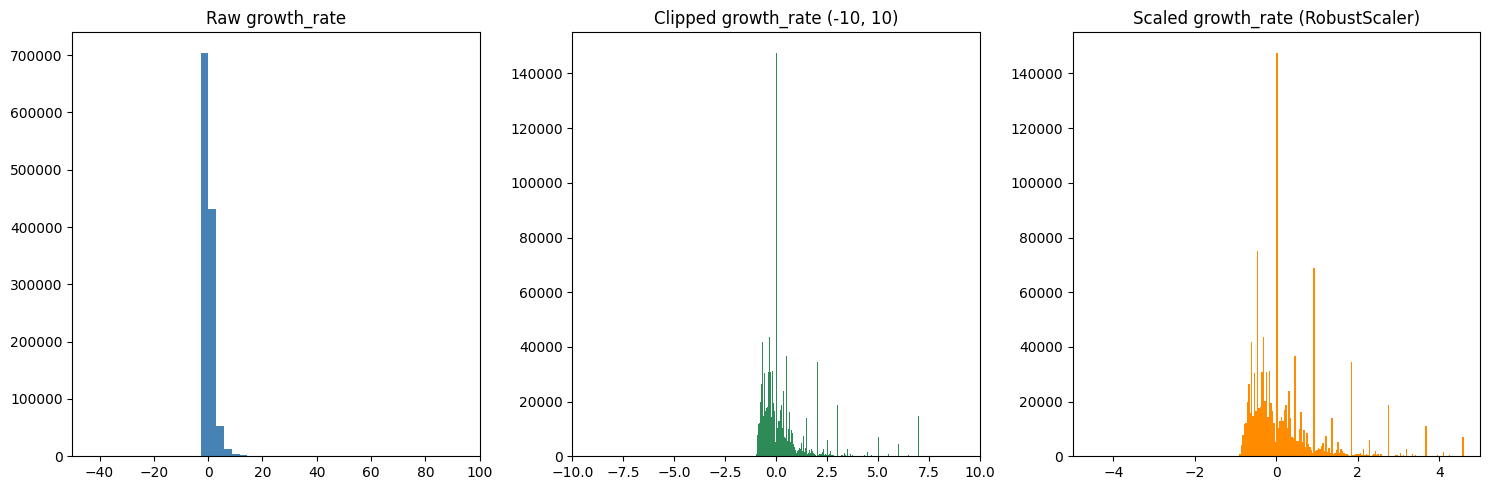

In [35]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Raw
axes[0].hist(df["y"], bins=200, color="steelblue", edgecolor="none")
axes[0].set_title("Raw growth_rate")
axes[0].set_xlim(-50, 100)  # zoom in to see bulk

# Clipped
axes[1].hist(df["y_clipped"], bins=200, color="seagreen", edgecolor="none")
axes[1].set_title("Clipped growth_rate (-10, 10)")
axes[1].set_xlim(-10, 10)

# Scaled
axes[2].hist(df["y_scaled"], bins=200, color="darkorange", edgecolor="none")
axes[2].set_title("Scaled growth_rate (RobustScaler)")
axes[2].set_xlim(-5, 5)

plt.tight_layout()
plt.show()


In [35]:
path = Path("../output/data/10_1000866.csv")
#df.query('store_item == "10_638308"')
df.query("store_item == '10_638308'").to_csv(path)

In [40]:
# Your data as a list of lists
data = [
    [39, 43, 4, 9, 14, 10, 14],
    [45, 58, 6, 12, 16, 7, 13],
    [1, 14, 3, 64, 21, 11, 15],
    [51, 49, 5, 11, 2, 0, 0],
    [0, 9, 2, 56, 0, 1, 2]
]

# Column names
columns = [1, 2, 3, 4, 5, 6, 7]

# Row labels
index = [1, 2, 3, 4, 5]

# Create DataFrame
df = pd.DataFrame(data, columns=columns, index=index)
# Set index name and dtype
df.index = df.index.astype("int64")  # ensure dtype
df.index.name = "store"              # set name

# Set columns dtype and name
df.columns = df.columns.astype("int64")  # ensure dtype
df.columns.name = "item"                 # set name
df

item,1,2,3,4,5,6,7
store,,,,,,,
1,39,43,4,9,14,10,14
2,45,58,6,12,16,7,13
3,1,14,3,64,21,11,15
4,51,49,5,11,2,0,0
5,0,9,2,56,0,1,2


In [41]:

# always coerce to float
X = df.to_numpy(dtype=np.float64)

est = BinaryTriFactorizationEstimator(
    n_row_clusters=9,         # try a few values (e.g., 3–8)
    n_col_clusters=4,
    k_row=None,               # no cap → multi-hard chosen by data
    k_col=None,
    loss="gaussian",
    alpha=1e-2,               # ridge on B for stability
    beta=0.4,                 # >0 makes memberships sparser
    block_l1=0.1,             # 0 = off; >0 = L1 on B (0.01 = good start)
    b_inner=15,               # inner prox steps for B when block_l1>0
    max_iter=60,
    tol=1e-5,
    random_state=42,
    verbose=False,
).fit(X)



In [42]:
#assign = est.filter_blocks(X= df.to_numpy(), min_keep=10)
mask   = est.allowed_mask_from_gap(min_keep=5)   # aim for ~5 colors
assign = est.assign_unique_blocks(X= X, method="gaussian_delta",
                                  allowed_mask=mask, on_empty="fallback")
block_id = assign["block_id"]  # (I×J), each cell → one color
df2 = get_normalized_assignments(assign, df)

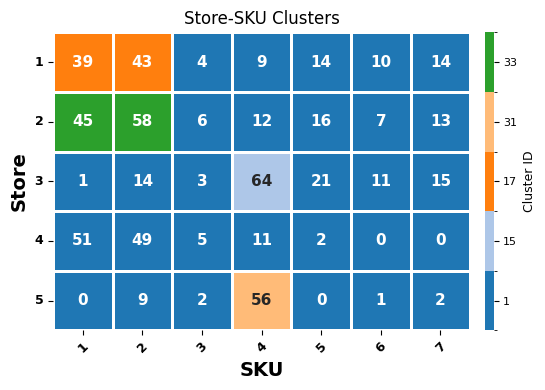

In [43]:
#row_order, col_order = est.get_row_col_orders(assign, df)
#row_order, col_order = est.get_row_col_orders(assign, norm_data2)
df2 = get_normalized_assignments(assign, df)  # contains unique per-cell block_id
#row_order, col_order = get_row_col_orders_smart(df2)
row_order = sorted(df2["store"].unique())
col_order = sorted(df2["item"].unique())

fn = Path("../output/figures/store_item_toy_data_heatmap.tiff")
plot_block_annot_heatmap(
    df2,
    ttl="Store-SKU Clusters",
    value_col="growth_rate_1", 
    block_col="block_id",
    row_col="store", 
    col_col="item",
    date_col=None,                
    row_order=row_order, 
    col_order=col_order,
    fmt= "{:.0f}",
    cell_h=0.6, 
    cell_w=0.75, 
    font_size=11,
    #figsize=(6, 4),
    x_label="SKU",
    y_label="Store",
    xlabel_size=14,
    ylabel_size=14,
    label_weight="bold",
    fn=None,
    xtick_rotation=45,
)

In [48]:
# Freeze your defaults once, then sweep:
make_btf = BinaryTriFactorizationEstimator.factory(
    k_row=None, 
    k_col=None, 
    loss="gaussian", 
    alpha=1e-2, 
    beta=0.6,
    block_l1=0.1,             # 0 = off; >0 = L1 on B (0.01 = good start)
    b_inner=15,               # inner prox steps for B when block_l1>0
    max_iter=50,
    tol=1e-5,
)
    
# Define your grid
R_list = range(1, 10)
C_list = range(1, 10)

# Run the sweep
grid_df = sweep_btf_grid(
    make_btf,
    X,
    R_list,
    C_list,
    restarts=3,
    seeds=range(123, 999),     # optional
    min_keep=6,
    fit_kwargs={"max_iter": 200, "tol": 1e-4},  # pass your estimator kwargs here
)

# Rank and pick the best (edit ranking logic inside pick_best_btf_setting if desired)
ranked_df, best = pick_best_btf_setting(grid_df)


2025-09-08 08:35:13,126 - INFO - Fitting BTF with R=1, C=1
2025-09-08 08:35:13,140 - INFO - Computing cell mask for R=1, C=1
/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/BTNMF_util.py:792: RuntimeWarning: Mean of empty slice
  float(np.nanmean(wcvdf["silhouette_like"]))
2025-09-08 08:35:13,145 - INFO - Fitting BTF with R=1, C=2
2025-09-08 08:35:13,165 - INFO - Computing cell mask for R=1, C=2
/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/BTNMF_util.py:792: RuntimeWarning: Mean of empty slice
  float(np.nanmean(wcvdf["silhouette_like"]))
2025-09-08 08:35:13,170 - INFO - Fitting BTF with R=1, C=3
2025-09-08 08:35:13,192 - INFO - Computing cell mask for R=1, C=3
2025-09-08 08:35:13,196 - INFO - Fitting BTF with R=1, C=4
2025-09-08 08:35:13,227 - INFO - Computing cell mask for R=1, C=4
2025-09-08 08:35:13,231 - INFO - Fitting BTF with R=1, C=5
2025-09-08 08:35:13,252 - INFO - Computing cell mask for R=1, C=5
2025-

In [49]:
best

n_row                                9.000000
n_col                                4.000000
Mask_Nobs                           11.000000
Mask_Coverage                        0.314286
seed                               123.000000
Loss                               193.697610
Percent_Loss                         0.825334
RMSE                                 2.352492
Percent_RMSE                         9.084789
PVE                                  0.977560
Mean Silhouette                      0.588852
BlockContribution_Total          18626.202594
BlockContribution_PerCell         1693.291145
BlockContribution_RelBaseline        5.808148
BlockContribution_FracWeak20         0.000000
BlockContribution_Gini               0.869474
B_Sparsity                           0.642857
Coverage                             1.000000
AIC                                215.928380
BIC                                230.252610
Name: 0, dtype: float64